In [8]:
#####SIMULATION#######
N = 5 #nbr of enclaves
M = 30 #nbr of machines
pe = 0.7
T = 20 #simulation time
r = 0.3 #passive reconnaissance over time
recon_percentage = 0.7 #how much time percentage to spend on recon
#times = [16,12,14,8] #sum <= T, time to spend in each enclave except the Internet enclave E0
times_shares = [1, 1, 1, 1] #times_share : 3 times share units in E1... their are T is divided between the shares (see coevolutionary algo)
times_sum = sum(times_shares)
times_share = int(T/times_sum)
times = [t*times_share for t in times_shares] #convert it into times
times[-1] += T-sum(times)
print("times = ",times)
beta = 3 #attacker spread in enclave
c = 0.9 #compromise appetite
a = 0.4 #information appetite
mission_impact = [(0.8,0.5) for i in range(M)] #list of mission impact and information impact for valuable machines 
mission_impact += [(0.8,0.5)]  #mission impact and information impact of firewall (Mth machine)
pupdate = 1/90 #update rate of each enclave
JUNK_MACHINES_NB = 5 #nbr of useless machines to add in enclave
#mi !=0 !!!! greater mission impact => greater back up time

for i in range(JUNK_MACHINES_NB):
    mission_impact += [(0.3,0.1)] #useless machines have 3 turns compromise dmg and poor information dmg

import numpy as np
import copy
import random
from itertools import islice
from random import randint
from IPython.display import SVG
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.topology import connected_components
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sknetwork.utils.format import bipartite2undirected
from scipy import sparse
import pandas as pd
from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.data import convert_edge_list, load_edge_list
from IPython.display import display

class enclave:
    def __init__(self,v,s,machines,adjacency):
        self.v = v
        self.sens = s
        self.machines = {m:0 for m in machines}
        self.machines[M] = 0 #Mth machine represents the firewall
        n_to_add = random.randint(0,JUNK_MACHINES_NB)#nbr of useless machines to add
        for useless in range(M+1,M+1+n_to_add): #add some useless machines
            self.machines[useless] = 0
        self.compromised = False
        self.next_hops = list(np.where(np.array(adjacency)==1)[0]) #nbr of connected enclaves to enclave
        
def get_adj(topo):
    adj = np.zeros((N,N))
    index = 0
    count = N-1
    topi = 0
    for i in range(N):
        adj[i][index+1::] = topo[topi:topi+count]
        index +=1
        topi += count
        count -=1
        
    for i in range(N):  #other side of diagonale should be zero or symetric ?
        for j in range(N):
            adj[j][i] = adj[i][j]
    #print(adj)
    return adj
    
def CVSS_sample():
    hist = [703,914,4880,4556,27455,23785,17054,27369,553,16185] #src : CVSS distribution https://www.cvedetails.com/cvss-score-distribution.php
    return np.random.choice(list(range(1,11)),1,p = [h/sum(hist) for h in hist])[0]/10

def init(ind):
    #print("ind = ",ind)
    topo = ind[0]
    sensitivities = ind[1]
    sensitivities_decoded = [0]+sensitivities #default vulnerability of the internet enclave
    distr = ind[2]
    distr_decoded = [[]] + distr#default no machines in the internet
    adj = get_adj(topo)
    v = [CVSS_sample() for j in range(N)]
    enclaves = [enclave(v[i],sensitivities_decoded[i],distr_decoded[i],adj[i]) for i in range(N)]
    
    adj_sk = sparse.csr_matrix(adj)
    labels = connected_components(adj_sk)
    names = ["Internet"]+["E"+str(i)+" v = "+str(enclaves[i].v)+" s = "+str(enclaves[i].sens) for i in range(1,N)]
    #if(np.sum(labels)>0):
        #print("unvalid architecture")
    image = svg_graph(adj_sk,labels=labels,names=names)
    x=SVG(image)
    #display(x)
    loss = attack(enclaves,T,times)
    
    #print("total loss = ",loss)
    return loss

def attack(enclaves,T,times):
    total_time = 0
    loss = 0
    internet = enclaves[0]
    internet.compromised = True
    compromised_enclaves_index = [0]
    already_compromised = [0] #enclaves that have been compromised in the past
 
    #internet starting point : useless ? start 
    """
    for e_index in internet.next_hops: #epidemic spread throughout enclaves
        e = enclaves[e_index]
        if (not e.compromised) and (not e_index in already_compromised):#dont spread to already compromised enclaves...
            infect = random.random()
            Network_IDS_intercept = random.random()
            print("internet_next_enclave_to_compromise = ",e_index)
            if infect < e.v and Network_IDS_intercept < pe: #vuln exploited and IDS failed to block
                print("success enclave infiltration")
                loss += spread(e,times[len(compromised_enclaves_index)-2])

                if(e.compromised): #enclave can be no longer compromised after failed spread
                    compromised_enclaves_index.append(e_index)

                already_compromised.append(e_index) #add infected enclave to already compromised list
                total_time += times[len(compromised_enclaves_index)-2]
                if (total_time >= T):
                    return loss
            else:
                print("failed enclave infiltration")
        total_time += 1
    """
    #print("times = ",times)
    while total_time < T:
        #print("time = ",total_time," / ",T)
        #print("compromised_enclaves_index = ",compromised_enclaves_index)
        for e in compromised_enclaves_index: 
            #print("current_compromised_enclave = ",e)
            enclave = enclaves[e]
            #print("enclave.next_hops = ",enclave.next_hops)
            for next_hop_index in enclave.next_hops:
                enclave_next_hop = enclaves[next_hop_index]
                #print("already compromised = ",already_compromised)
                if (not enclave_next_hop.compromised):#dont spread to compromised enclaves...
                    #print("next_hop_index_tentative = ",next_hop_index)
                    infect = random.random()
                    Network_IDS_intercept = random.random()
                    if infect < enclave_next_hop.v and Network_IDS_intercept < pe: #vuln exploited and IDS failed to block
                        #print("success enclave infiltration")
                        #can spread to already compromised enclaves in the past, but can't get information gain
                        loss += spread(enclave_next_hop,times[next_hop_index-1],not (next_hop_index in already_compromised))
                        already_compromised.append(next_hop_index) #add infected enclave to already compromised list
                        #even if later recovered by cleansing
                        if(enclave_next_hop.compromised): #enclave can be no longer compromised after failed spread
                            compromised_enclaves_index = copy.deepcopy(compromised_enclaves_index)
                            #deepcopy to prevent affecting the for loop dynamically
                            compromised_enclaves_index.append(next_hop_index)
                        total_time += times[next_hop_index-1] #time to spend in enclave next_hop_index
                        if (total_time >= T):
                            return loss
                    #else:
                        #print("failed enclave infiltration")
        total_time += 1
        #print("time incremented")
    return loss
            

#enclave spread
def spread(enclave,time,info_loss_to_get):
    #print("info_loss_to_get = ",info_loss_to_get) #if enclave already compromised, no info loss to get
    enclave.compromised = True
    loss = 0 #loss 
    recon_time = int(recon_percentage*time)  #recon time
    machines_index = list(enclave.machines.keys()) #machines in enclave
    #print("machines_index = ",machines_index)
    n_machines = len(machines_index) #nbr machines in enclave
    
    first_infected = np.random.choice(machines_index,1)[0] #the first machine to be infected is drawn uniformly between all machines in enclave
    enclave.machines[first_infected] = 1 #machine infected
    already_infected = {m:0 for m in machines_index} #machines infected at some point even if back up later after compromise
    already_infected[first_infected] = 1
    discovered_machines_index = [first_infected] #list of discovered machines 
    
    #convert mission impact in 0,1 to back up time by multiplying it by 10
    turned_down = {m:[False,int(mission_impact[m][0]*10)] for m in machines_index}#turned down machines and their mission delay time
    #print("turned_down = ",turned_down)
    #to indicate how much time left before back up
    
    #prior values of machines
    total_prior_values = {m:a*0.2*int(info_loss_to_get)+c*0.2 for m in machines_index} #prior values of machine, default = pessimistic
    
    
    #reconnaissance FIRST
    #print("time = ",time)
    #print("recon_time = ",recon_time) 
    for t in range(recon_time):
        #print("t= ",t, " / ",time)
        update = random.random()
        if (update < pupdate): #"pseudo probability of enclave update"
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False
            #print("update !!")
            #print("loss = ",loss)
            #print("spread done")
            return loss
        #print("recon...")
        not_discovered = list(set(machines_index)-set(discovered_machines_index))
        if(len(not_discovered)>0): #if there are some machines left to discover
            discovered_machine = np.random.choice(not_discovered,1)[0]
            discovered_machines_index += [discovered_machine]
            total_prior_values[discovered_machine] = a*mission_impact[discovered_machine][1]*int(info_loss_to_get)+c*mission_impact[discovered_machine][0]

    
    #information stealing and(maybe) shutting down of this first machine (its mission service)
    #print("first machine infected : ",first_infected)
    loss -= a*mission_impact[first_infected][1]*int(info_loss_to_get) #update information loss
    #print("loss of first machine = ",loss)
    #compromise or not ??? => more likely if high compromise value and compromise appetite
    compromise_pseudo_proba = (c+mission_impact[first_infected][0])/2
    compromise = random.random()
    if compromise < compromise_pseudo_proba:
        #print("first machine turned down : ",first_infected)
        turned_down[first_infected][0] = True
        nbr_turned_down = len([m for m in list(turned_down.keys()) if turned_down[m][0]])
        threshold = nbr_turned_down * enclave.sens
        if random.randint(0,nbr_turned_down)<threshold: #when turned down treshold reached : enclave cleansing 
            #print("enclave cleansing due to many downed (only first) machines")
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False #enclave no longer compromised
            loss -= sum([mission_impact[m][0] for m in machines_index])/2 #half mission delay for all machines 
            #because there is no detection and investigation time
            #print("loss after only first down = ",loss)
            #print("spread done (first only)")
            return loss 
        else:
            loss -= c*mission_impact[first_infected][0] #update turned down loss
            #print("loss = ",loss)
            #machine to be back up after mission delay time and no longer infected
    
    if(len(machines_index)==1): #enclave only has one firewall-IDLE machine, return default loss
        #print("loss = ",loss)
        #print("spread done, only one machine, nothing to do")
        return loss
    
    #spreading phase
    for t in range(recon_time,time):
        #print("t= ",t, " / ",time)
        
        update = random.random()
        if (update < pupdate): #"pseudo probability of enclave update"
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False
            #print("update !!")
            #print("loss = ",loss)
            #print("spread done")
            return loss
        
        #get machine back up after being turned down, if attacker no longer has a foothold, he is kicked out : 
        #enclave no longer compromised in this case
        for m,v in turned_down.items():
                if v[0]:
                    turned_down[m][1] -=1
                    if turned_down[m][1] == 0:
                        #print("machine back up : ",m)
                        turned_down[m][0] = False #machine back up
                        turned_down[m][1] = mission_impact[m][0]
                        enclave.machines[m] = 0 #machine no longer infected
                        if(len([m for m in list(enclave.machines.keys()) if enclave.machines[m] == 1]) == 0):
                            enclave.compromised = False #enclave no longer compromised
                            #print("spread done, no more foothold in enclave")
                            #print("loss = ",loss)
                            return loss
                        
        #print("spreadingggg")
        #print("discovered_machines_index = ",discovered_machines_index)
        #print("total_prior_values = ",total_prior_values)

        #candidate targets are those that have not yet been infected
        candidate_values = {m:total_prior_values[m] for m in list(enclave.machines.keys()) if already_infected[m]==0} 
        #print("candidate_values = ",candidate_values)
        #choose which machines to infectsort total values by values get beta best machines with respect to their weighted values
        nbr_to_infect = min(beta,len(list(candidate_values.keys())))
        to_infect = dict(sorted(candidate_values.items(), key=lambda x: x[1], reverse=True)[:nbr_to_infect])
        #print("to_infect = ",to_infect)
        
        #try to spread to to_infect
        IDS_ALERT = 0
        for machine_to_infect,value in to_infect.items():
            #print("machine_to_infect = ",machine_to_infect)
            Enclave_IDS_intercept = random.random()
            if Enclave_IDS_intercept < pe: #IDS failed to block infection succeeded
                #print("machine infected")
                enclave.machines[machine_to_infect] = 1 #machine is infected
                already_infected[machine_to_infect] = 1 #machine is added to already infected list
                loss -= a*mission_impact[machine_to_infect][1]*int(info_loss_to_get) #update information loss
                #print("loss = ",loss)
                #compromise or not ??? => more likely if high compromise value and compromise appetite
                compromise_pseudo_proba = (c+mission_impact[machine_to_infect][0])/2
                compromise = random.random()
                if compromise < compromise_pseudo_proba:
                    #print("machine turned down")
                    turned_down[machine_to_infect][0] = True
                    nbr_turned_down = len([m for m in list(turned_down.keys()) if turned_down[m][0]])
                    threshold = nbr_turned_down * enclave.sens
                    if random.randint(0,nbr_turned_down) < threshold: #when turned down treshold reached : enclave cleansing 
                        #print("enclave cleansing due to many downed machines")
                        for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                            enclave.machines[key] = 0
                        enclave.compromised = False #enclave no longer compromised
                        loss -= sum([mission_impact[m][0] for m in machines_index])/2 #half mission delay for all machines 
                        #because there is no detection and investigation time
                        #print("loss = ",loss)
                        #print("spread done")
                        return loss 
                    else:
                        loss -= c*mission_impact[machine_to_infect][0] #update turned down loss
                        #machine to be back up after mission delay time and no longer infected
                        #print("loss = ",loss)




            else: #infiltration blocked
                #print("machine infection failed")
                IDS_ALERT += 1 #raise alert level
                threshold = IDS_ALERT * enclave.sens
                if random.randint(0,n_machines)<threshold: #when treshold reached : enclave cleansing 
                    #print("enclave cleansing due to many infiltration attempts")
                    for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                        enclave.machines[key] = 0
                    enclave.compromised = False #enclave no longer compromised
                    loss -= sum([mission_impact[m][0] for m in machines_index])/2 #half mission delay for all machines 
                    #because there is no detection and investigation time
                    #print("loss = ",loss)
                    #print("spread done")
                    return loss 
    
    #print("loss = ",loss)                    
    #print("spread done")
    return loss
            


times =  [5, 5, 5, 5]


In [9]:
def partition (list_in, n): #partitions a list into n pseudorandom chunks of size between 0 and M.
    b=copy.deepcopy(list_in)
    random.shuffle(b)
    it = iter(b)
    size = len(b)
    res = []
    for i in range(n - 1,0,-1):
        s = random.randint(0, size -  0 * i)
        res += [list(islice(it,0,s))]
        size -= s
    res+=[list(it)]
    random.shuffle(res)
    return res

def initialize():
    topo = list(np.random.randint(low = 0,high=2,size=int(N*(N-1)/2)))
    sensitivities = list(np.random.random_sample(size = N-1))
    distribution = partition(list(range(0,M)),N-1)
    return [topo,sensitivities,distribution]

individual = initialize()
#individual[0] = [1,0,0,0,1,0,0,1,0,1] #linear graph
#individual[0] = [1,1,1,1,1,1,1,1,1,1] #fully connected graph
individual[0] = [1,0,1,0,1,0,0,1,1,0] #parellel-like graph
#individual[2][1] = [i for i in range(27)]
#print(individual[2])
res = np.mean(np.array([init(individual) for i in range(5)]))
print("res = ",res)

res =  -10.31


unvalid architecture


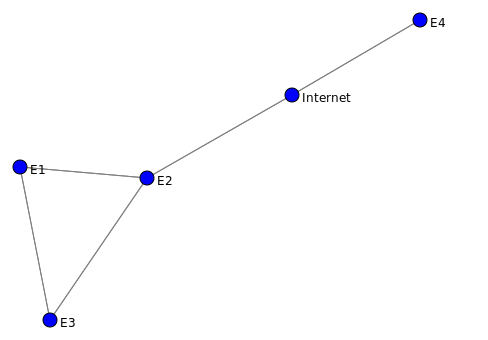

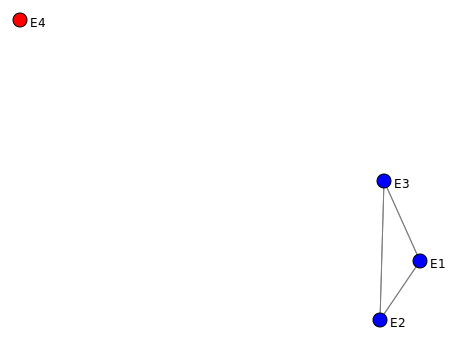

In [10]:
#optional solution (not used : prefer sknetwork)
##################
def DFS(adj, enclave, visited_enclaves):
    visited_enclaves[enclave] = True
    for next_enclave in adj[enclave]:
        if not visited[next_enclave]:
            DFS(adj, next_enclave, visited_enclaves)
            
def is_connected(adj):
    n_enclaves = len(adj)
    for enclave in range(n_enclaves):
        visited_enclaves = [False for j in range(n)]
        DFS(adj, enclave, visited_enclaves)
        for check in visited:
            if not check:
                return False
 
    return True
#####

topo = list(np.random.randint(low = 0,high=2,size=int(N*(N-1)/2)))
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i) for i in range(1,N)]
if(np.sum(labels)>0):
    print("unvalid architecture")
image = svg_graph(adj,labels=labels,names=names)

x=SVG(image)

adjacency_without_internet = np.delete(adjacency[1:],0,axis=1)
adj_without_internet = sparse.csr_matrix(adjacency_without_internet)
labels = connected_components(adj_without_internet)
names = ["E"+str(i) for i in range(1,N)]
image = svg_graph(adj_without_internet,labels=labels,names=names)
if(np.sum(labels)>0):
    print("unvalid architecture")
y=SVG(image)
display(x,y)

def is_valid(topo):
    adjacency = get_adj(topo)
    adj = sparse.csr_matrix(adjacency)
    if(sum(topo)==0): #no edge
        return False
    labels = connected_components(adj)
    if(np.sum(labels)>0): #if graph is not connected, not valid
        return False
    adjacency_without_internet = np.delete(adjacency[1:],0,axis=1)
    labels = connected_components(adj_without_internet)
    if(np.sum(labels)>0): #if graph not connected without the Internet, not valid also
        return False
    return True

In [30]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

from qdpy.algorithms.deap import *
from qdpy.containers import *
from qdpy.benchmarks import *
from qdpy.plots import *
from qdpy.base import *

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from itertools import chain
from itertools import islice
from random import randint

import os
import numpy as np
import random
import warnings
import scipy
import math
import array
import copy

from IPython.display import SVG
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.topology import connected_components
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sknetwork.utils.format import bipartite2undirected
from scipy import sparse
import pandas as pd
from sknetwork.utils import edgelist2adjacency, edgelist2biadjacency
from sknetwork.data import convert_edge_list, load_edge_list
from IPython.display import display

###################################

def is_valid(topo): #1D topo
    adjacency = get_adj(topo)
    adj = sparse.csr_matrix(adjacency)
    if(sum(topo)==0): #no edge
        return False
    labels = connected_components(adj)
    if(np.sum(labels)>0): #if graph is not connected, not valid
        return False
    adjacency_without_internet = np.delete(adjacency[1:],0,axis=1)
    labels = connected_components(adjacency_without_internet)
    if(np.sum(labels)>0): #if graph not connected without the Internet, not valid also
        return False
    return True


def partition (list_in, n):
    b=copy.deepcopy(list_in)
    random.shuffle(b)
    it = iter(b)
    size = len(b)
    res = []
    for i in range(n - 1,0,-1):
        s = random.randint(0, size -  0 * i)
        res += [list(islice(it,0,s))]
        size -= s
    res+=[list(it)]
    random.shuffle(res)
    return res


def initialize():
    topo = list(np.random.randint(low = 0,high=2,size=int(N*(N-1)/2)))
    if (not is_valid(topo)):
        return initialize()
    sensitivities = list(np.random.random_sample(size = N-1)) #internet has no sensitivity
    distribution = partition(list(range(0,M)),N-1) #internet has no "machines"
    return [topo,sensitivities,distribution]
    
    

def evaluate(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    #print("ind = ",len(ind))
    score = np.mean(np.array([init(ind) for i in range(5)])).item()
    fit0 = sum(ind[0])
    #fit1 = np.mean(ind[1])
    fit2 = np.std(np.array([len(l) for l in ind[2]])) #how sparse are machines
    features = [fit0, fit2]
    return (score,), features
    

toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # fitness
creator.create("Individual", list, fitness=creator.FitnessMax,features=list)
def individual():
    return creator.Individual(initialize())
#toolbox.register("initialize", initialize)
#toolbox.register("individual_old", tools.initRepeat, creator.Individual, toolbox.initialize, n=1)
toolbox.register("individual", individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
#toolbox.register("mate_topo", tools.cxTwoPoint)
def mate_strategy(parent1,parent2): #only mate 2 topo MUTATION NOT USED IN QD !!!!
    topo1, topo2 = tools.cxTwoPoint(parent1[0], parent2[0])
    res1,res2 = parent1,parent2
    res1[0] = topo1
    res2[0] = topo2
    a=2/0 #test to detect if its called in QD algo or not => IT IS NOT USED
    return res1,res2
toolbox.register("mate", mate_strategy)
#
toolbox.register("mutate_topo", tools.mutFlipBit, indpb=0.05)
eta = 20.0
mutation_pb = 0.4
toolbox.register("mutate_sens", tools.mutPolynomialBounded, low=0, up=1, eta=eta, indpb=mutation_pb)
def mutate_strategy(individual): #changes in place and return the individual 
    
    #print("MUTATION")
    #mutation of 1D topo
    mutated_topo = toolbox.mutate_topo(individual[0])
    if (not isinstance(mutated_topo[0],list)):
        #print("TOPO NOT A LIST")
    if (not is_valid(mutated_topo[0])): #check validity of mutated topo
        #print("NOT VALID MUTATION")
        return mutate_strategy(individual)
    
    #mutation of sensibilities
    mutated_sens = toolbox.mutate_sens(individual[1])
    
    #mutation of valuable machine distribution
    distr = copy.deepcopy(individual[2])
    PC = random.choice(list(chain.from_iterable(distr)))
    index = [i for i in range(0,N-1) if PC in distr[i]]
    index = index[0]
    new_enclave = random.choice([i for i in range(N-1) if i!=index])
    mutated_distr = copy.deepcopy(distr)
    mutated_distr[index].remove(PC)
    mutated_distr[new_enclave].append(PC)
    
    individual[0] = copy.deepcopy(mutated_topo[0])
    individual[1] = copy.deepcopy(mutated_sens[0])
    individual[2] = copy.deepcopy(mutated_distr)
    return individual,
toolbox.register("mutate",mutate_strategy)
#
toolbox.register("select", tools.selRandom) # MAP-Elites = random selection on a grid container
###################################




if __name__ == "__main__":
    T = 20
    #print("N = ",N)
    # Algorithm parameters
#    dimension = args.dimension                # The dimension of the target problem (i.e. genomes size)
    nb_features = 2                            # The number of features to take into account in the container
    nb_bins = [10,10]
#    ind_domain = (0., 1.)                     # The domain (min/max values) of the individual genomes
    features_domain = [(0, 10), (0.,20.)]      # The domain (min/max values) of the features
    fitness_domain = [(-20, 0)]               # The domain (min/max values) of the fitness

    #init_batch_size = 3000                     # The number of evaluations of the initial batch ('batch' = population)
    #3000 or 400 ?
    init_batch_size = 400
    batch_size = 400                           # The number of evaluations in each subsequent batch
    nb_iterations = 10                        # The number of iterations (i.e. times where a new batch is evaluated)
    cxpb = 0.5
    mutation_pb = 1                            # The probability of mutating each value of a genome
    max_items_per_bin = 1                      # The number of items in each bin of the grid
    verbose = False                         
    show_warnings = True                      # Display warning and error messages. Set to True if you want to check if some individuals were out-of-bounds
    log_base_path = "."
    parallelismType = "multithreading"

    # Update and print seed
    seed = 7
    np.random.seed(seed)
    random.seed(seed)

    
    # Build a dict storing all relevant infos
    results_infos = {}
#   results_infos['dimension'] = dimension
#   results_infos['ind_domain'] = ind_domain
    results_infos['features_domain'] = features_domain
    results_infos['fitness_domain'] = fitness_domain
    results_infos['nb_bins'] = nb_bins
    results_infos['init_batch_size'] = init_batch_size
    results_infos['nb_iterations'] = nb_iterations
    results_infos['batch_size'] = batch_size
#   results_infos['mutation_pb'] = mutation_pb
#   results_infos['eta'] = eta

    grid = containers.Grid(shape=nb_bins, max_items_per_bin=max_items_per_bin, fitness_domain=fitness_domain, features_domain=features_domain,storage_type=list)

    with ParallelismManager(parallelismType,toolbox=toolbox) as pMgr:
        algo = DEAPQDAlgorithm(pMgr.toolbox, grid, init_batch_size = init_batch_size, batch_size = batch_size, niter = nb_iterations,
                cxpb = cxpb, mutpb = mutation_pb,
                verbose = verbose, show_warnings = show_warnings, results_infos = results_infos, log_base_path = log_base_path)
        # Run the illumination process !
        algo.run()

        #best = algo.optimise(eval_fn, executor = pMgr.executor, batch_mode=False) # Disable batch_mode (steady-state mode) to ask/tell new individuals without waiting the completion of each batch

    # Print results info
    print(f"Total elapsed: {algo.total_elapsed}\n")
    print(grid.summary())
    print("#########################################################")
    print("QD score = ",grid.qd_score())
    print(grid.best)
    plot_path = os.path.join(log_base_path, "performancesGrid.pdf")
    plotGridSubplots(grid.quality_array[... ,0], plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, grid.fitness_extrema[0], nbTicks=None)
    print("\nA plot of the performance grid was saved in '%s'." % os.path.abspath(plot_path))

    plot_path = os.path.join(log_base_path, "activityGrid.pdf")
    plotGridSubplots(grid.activity_per_bin, plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, [0, np.max(grid.activity_per_bin)], nbTicks=None)
    print("\nA plot of the activity grid was saved in '%s'." % os.path.abspath(plot_path))

    print("All results are available in the '%s' pickle file." % algo.final_filename)


    


MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATIO

MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTA

MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VA

MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUT

MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUT

MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION


NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
NOT VALID MUTATION
MUTATION
MUTATION
MUTATION
MUTATION
MUTATION


In [514]:
import copy
from itertools import islice
from random import randint

M = 30
def partition (list_in, n):
    b=copy.deepcopy(list_in)
    random.shuffle(b)
    it = iter(b)
    size = len(b)
    res = []
    for i in range(n - 1,0,-1):
        s = random.randint(0, size -  0 * i)
        res += [list(islice(it,0,s))]
        size -= s
    res+=[list(it)]
    random.shuffle(res)
    return res
distr = partition(list(range(0,M)),N)
print(distr)

[[8, 0, 25, 6, 7, 14, 3, 19, 11, 28, 24, 12, 16], [], [18, 17, 21, 13, 20, 15, 23, 4, 5, 26, 10, 9, 2, 22], [], [29, 27, 1]]
